<h1><Center> Time Series Analysis Using ARIMA and Auto ARIMA

---------

### ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset using pd.read_csv
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
# Checking in what iss in our df
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


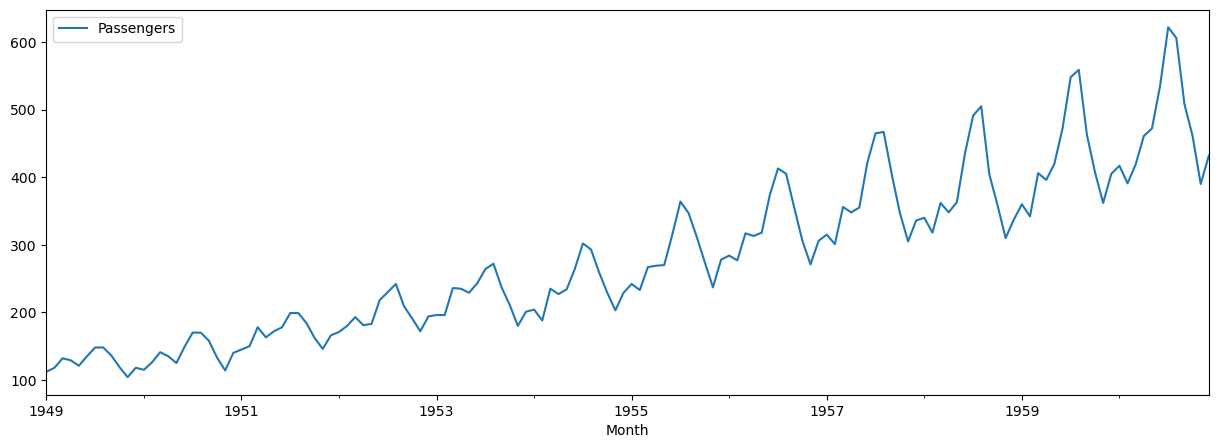

In [4]:
# Checking what our dataset looks like
df.plot(figsize=(15, 5));

In [5]:
# Calculating the 1st difference in our data to make the TS stationary
df['1stdiff'] = df['Passengers'].diff()

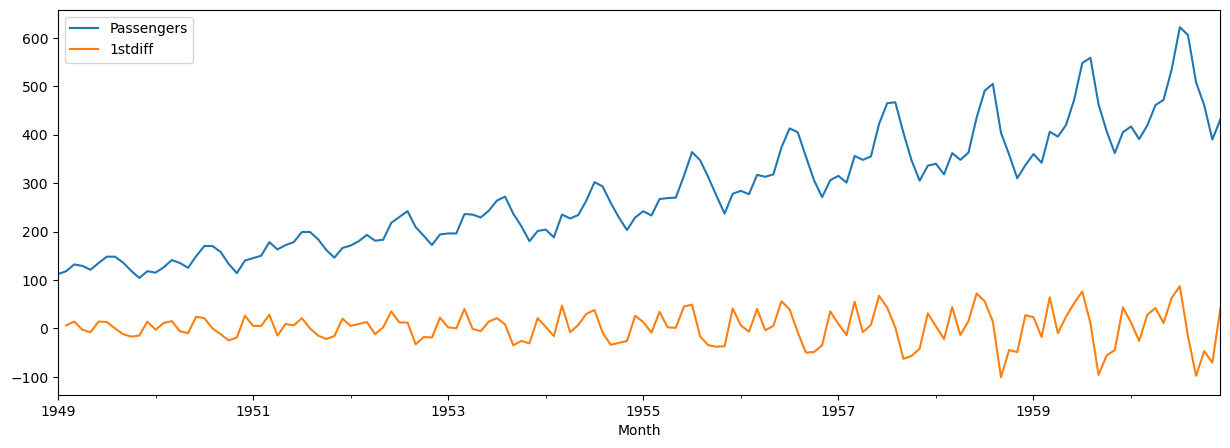

In [6]:
# Plotting the df to check what the 1st difference of the TS looks like
df.plot(figsize=(15, 5));

As we can see, it's not quite stationary because there is some seasonality and the variation is increasing over time.

In [7]:
# Computing the log of the "Passengers" column
df['LogPassengers'] = np.log(df['Passengers'])

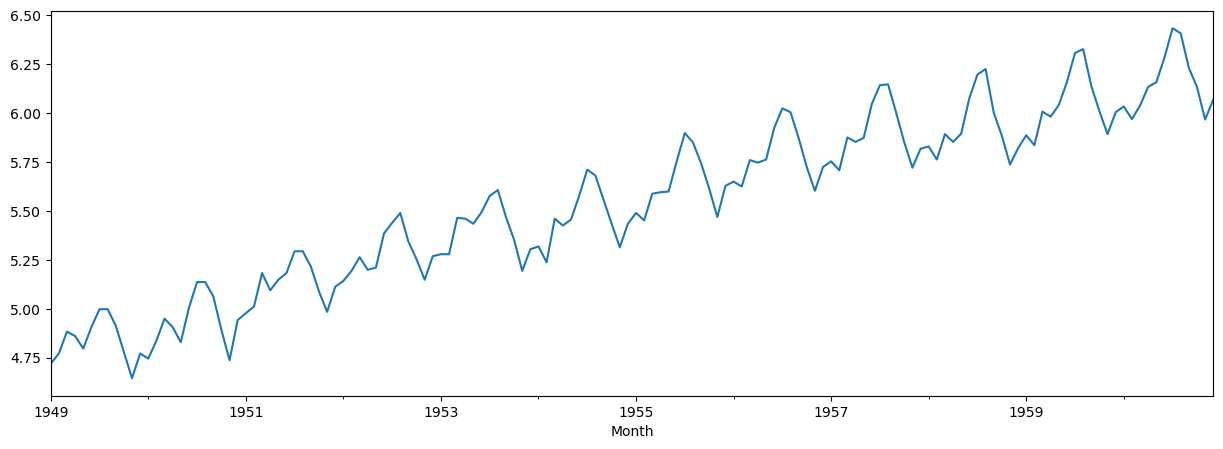

In [8]:
# Plotting the "LogPassengers" column
df['LogPassengers'].plot(figsize=(15, 5));

The values don't seem to be growing as rapidly as they were in the non-logged time series.

Furthermore, the amplitude of the cycles looks more constant than it was before.

In [9]:
# Importing the Arima class from stats models 
from statsmodels.tsa.arima.model import ARIMA

In [10]:
# Setting the frequency of our df index to Months
df.index.freq = 'MS'

# Also, splitting the data into train and test using the last 12 months of our dataset as the test set
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [11]:
# Create a train_idx and test_idx in order to index our df in either the train or test rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
# Testing AR(1) model
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [13]:
# Calling arima.fit()
arima_result = arima.fit()

In [14]:
# Calling arima_result.predict() to obtain the training predictions
# We'll place this in a new column in our df called "AR(1)"
df.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1])

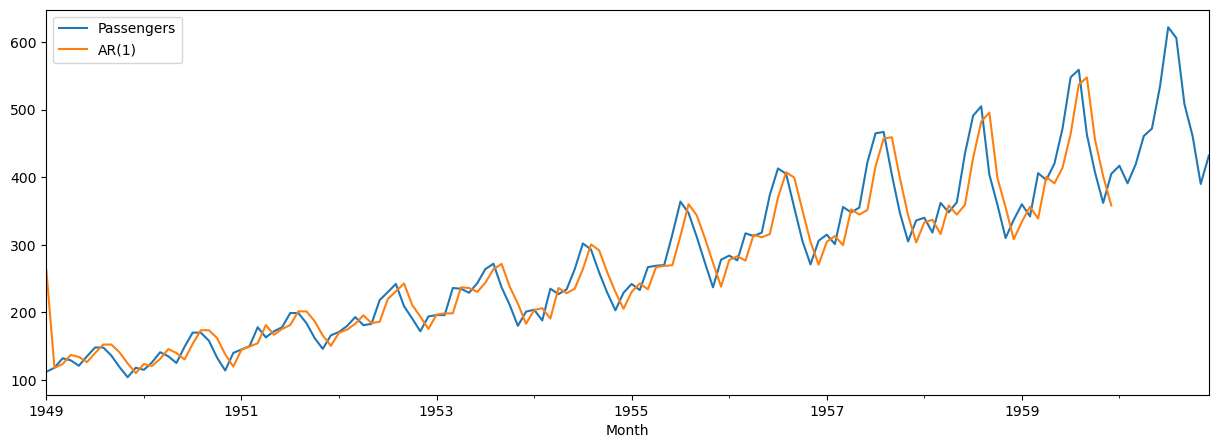

In [15]:
# Plotting the "Passengers" column along with the "AR(1)" column to see how well our model fits with the data
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

As we can see, we get this kind of delayed behavior, which reminds us of Holt's Linear Trend Model.

In [16]:
# Grabbing our out-of-sample predictions by calling "arima_result.get_forecast()" for Ntest steps
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

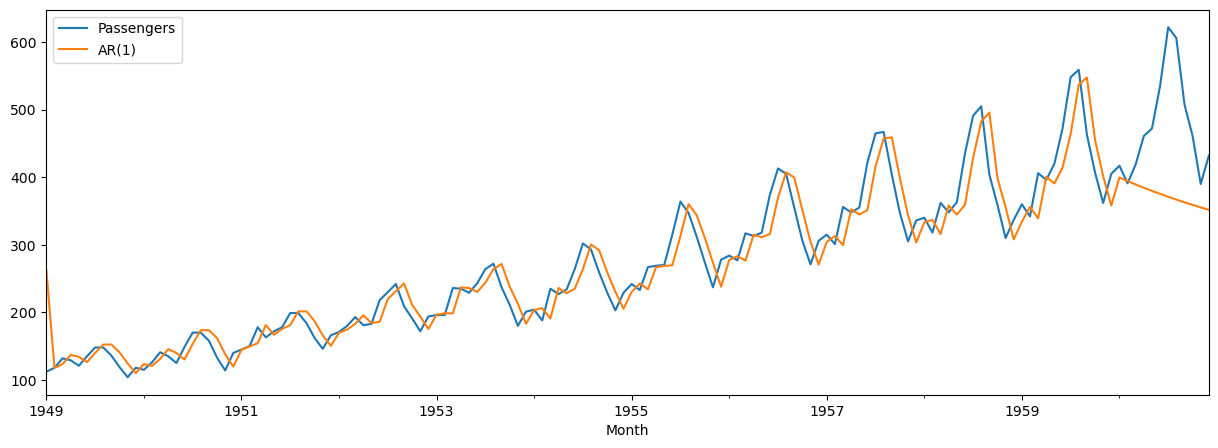

In [17]:
# Plotting AR(1) column again, against the "Passengers" data
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

As we can see, this model is not very good. In fact, it doesn't even capture the fact that the data is trending upwards. Instead the forecast is going in completely the wrong direction. 

So even a Naive Forecast would be better than this.

In [18]:
# Obtaining our Confidence intervals by using conf_int() from statsmodels
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826172,478.809354
1960-03-01,287.732169,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373403,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


Writing a function that will plot the fitted values of an ARIMA model along with the forecast and confidence intervals. This will be helpful for the rest of this script so that we don't have to keep writing this code over and over again.

In [19]:
# This function, it takes in one argument, which is an "ARIMA result" object.
def plot_fit_and_forecast(result):
    # Inside the function, the first thing we do is set the size of the plot, which will be 15 columns by 5 rows.
    fig, ax = plt.subplots(figsize=(15, 5))
    # Next, we call in the plot function to pass in the "Passengers" column of the df. This will plot the true data.
    ax.plot(df['Passengers'], label='data')

# -----------------------------------------------------------------------------------------------------------------

    # Plot the curve fitted on train set
    
    # We're going to obtain the train predictions by calling "result.fittedvalues"
    train_pred = result.fittedvalues
    # We plot the train predictions by calling the plot function again, passing in the train index along with the train predictions that we just obtained.
    ax.plot(train.index, train_pred, color='green', label='fitted')

# -----------------------------------------------------------------------------------------------------------------
    
    # Forecast the test set
    
    # Calling "result.get_forecast(Ntest)". This gives us prediction results object.
    prediction_result = result.get_forecast(Ntest)
    # Calling the "conf_int()" in order to get a df containing the confidence intervals
    conf_int = prediction_result.conf_int()
    # Assigning these confidence interval columns to a variable called "lower" and "upper"
    lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
    # Next step is to grab our forecast to obtain the actual predicted values. This uses the attribute "predicted_mean".
    forecast = prediction_result.predicted_mean
    # We'll call the plot() again, this time passing in the test index along with the forecast values. We'll give this the label "Forecast"
    ax.plot(test.index, forecast, label='forecast')
    # In order to plot the confidence bounds, we'll use the function fill_between(). The arguments to this will be the test index once again, the lower and upper values, the color red and alpha = 0.3 for transparency.
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    # Lastly we call "ax.legend()" so that the legend will show up in our plot
    ax.legend()

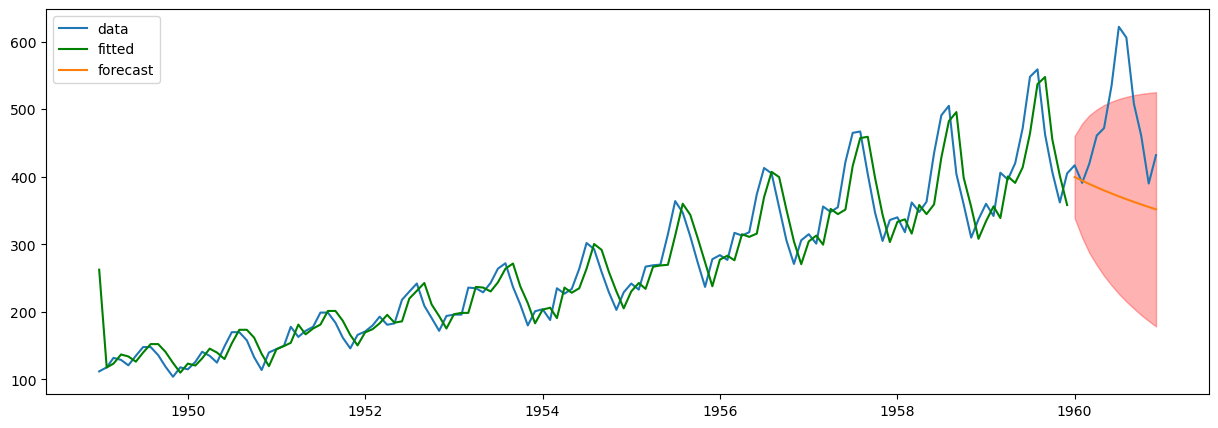

In [20]:
# Testing the function that we just created by passing in the "arima_result" object we got back earlier
plot_fit_and_forecast(arima_result)

This is our AR(1) forecast again. Not very good, but we can try other option next.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


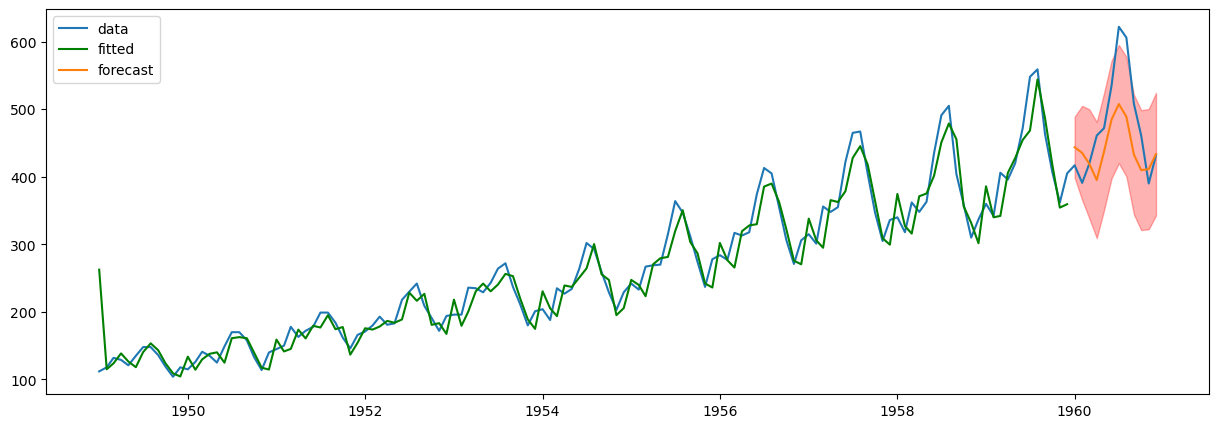

In [21]:
# Trying an AR(10) model

# Creating another ARIMA object with the order (10,0,0)
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
# Next, we call armia.fit()
arima_result = arima.fit()
# Passing the arima_result into our plotting function
plot_fit_and_forecast(arima_result)

We see that this model does a much better job.

The first thing we notice is that it does not has the lagging characteristic that the previous AR(1) model had. This suggests that the model is actually learning to anticipate the pattern rather than just copying the last value.

If we look at the forecast, we see that the model really does learn that the signal is periodic. Unfortunately, it seems to underestimate the true value significantly.

------------------------------------------

**Testing MA(1) Model**

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


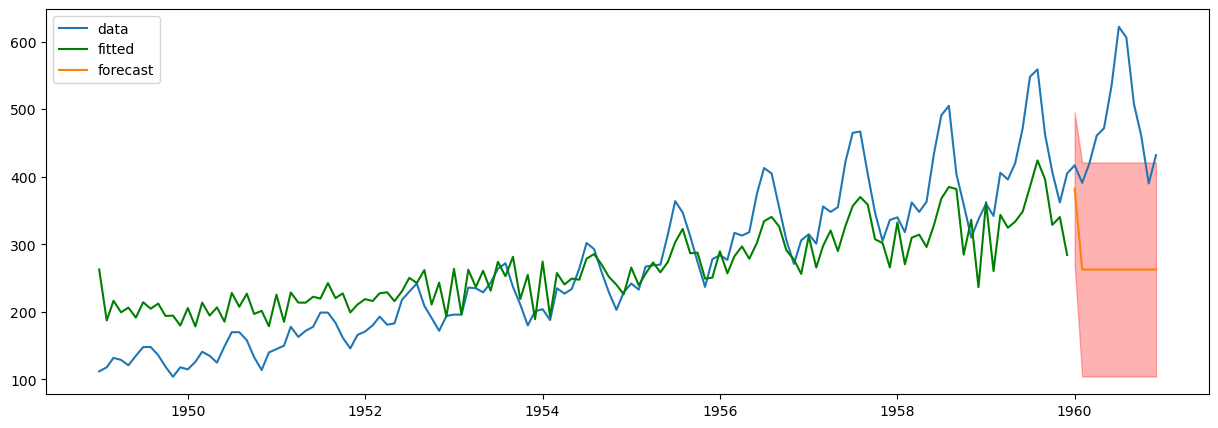

In [22]:
# We can run the same code from earlier, but for MA(1)
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

This looks pretty bad.

It's clear that the MA(1) model does not work. In fact, it's even worse than AR(1).

We know that the moving average models expected forecast is always a constant value. So intuitively, we know that this is probably not the right choice.

All right, so next we're going to investigate using the "LogPassengers". Let's begin by taking the 1st difference of the log passengers.

Again, we use the diff() function.

In [23]:
df['Log1stDiff'] = df['LogPassengers'].diff()

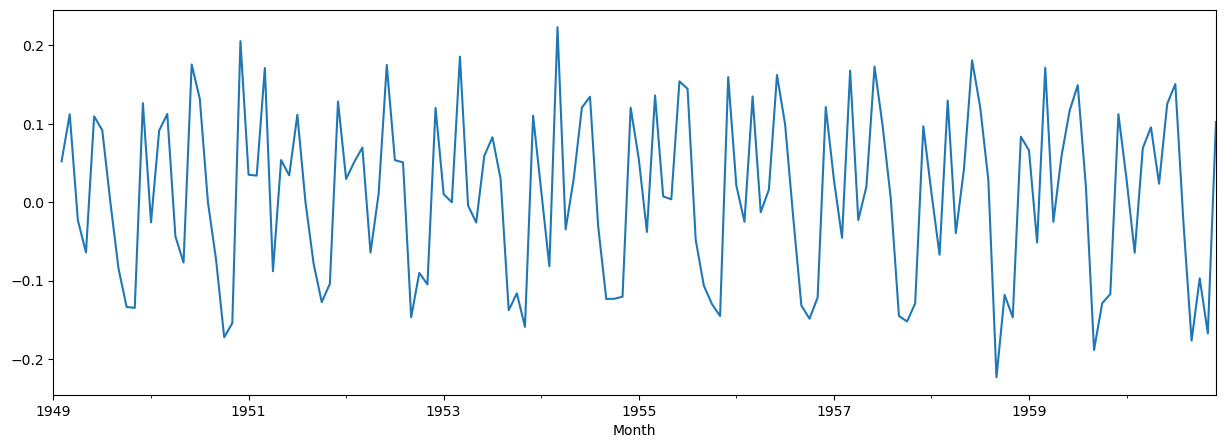

In [24]:
# Plot the 1st difference of the "LogPassengers"
df['Log1stDiff'].plot(figsize=(15, 5));

As you can see, the behavior is indeed what we expected.

Unlike the 1st difference of the "non-logged" passengers, these values do not seem to grow that much over time.

All right, so next, before we do anything with the log passengers, we fit a new model on the non-log passengers. We know that differencing is good because it at least seems to remove the trend.

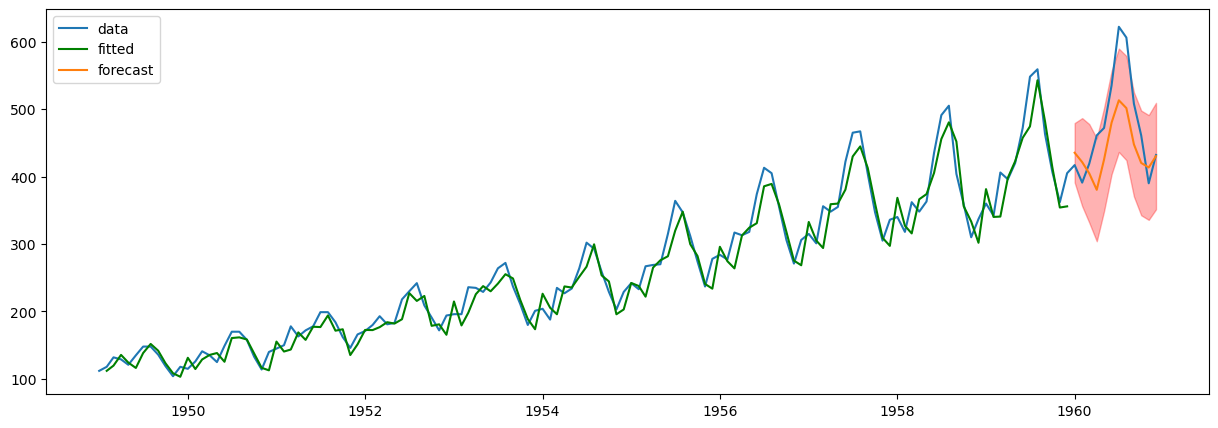

In [25]:
# We've choosen p=8, since it seems like regression on more past values helps, 
#               d=1, since it seems to remove trend from the TS,
#               q=1, for good measure, just so that we have a full ARIMA model
arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

"""
In order to plot the results from this ARIMA, we're going to need to create a new function because we've differenced our data
When we difference our data this removes 1 row from our dataset, specifically the 1st row. 
Each point in the differenced time series is the current value -  last value. But for the first row there is no last value and therefore that value can't exist.
We'll see that if we try to use the previous function that we wrote for plotting the results, we will get an error.
""";

# The function takes 3 arguments compared to 1 previously.
# The 3 arguments are: 
# a. ARIMA results object, 
# b. Value of D (D will represent the 1st row in the Differenced Time series that actually exists) 
# c. Col, tells us which column of the df we fit the model on . 
#    That'll either be "Passengers" or "LogPassengers" and we've to choose the appropriate one in order to plot the correct data with the model predictions.
def plot_fit_and_forecast_int(result, d, col='Passengers'):
    # Inside the function we first plot the data
    fig, ax = plt.subplots(figsize=(15, 5))
    # We index the df using the col argument (unlike a fixed column name previously)
    ax.plot(df[col], label='data')

#--------------------------------------------------------------------------------------------

    # Plot the curve fitted on train set
    """
    We grab our training predictions using the predict().
    We've used the predict() so that we can be explicit about our indices, but also because it's necessary in order to get the values back in terms of the original TS rather than the differenced TS.
    Notice that for the index we're only passing in the values for the "dth" row onward.
    """;
    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

#--------------------------------------------------------------------------------------------

    # Forecast the test set
    
    # Next, we plot the forecast. This part is the same as before.
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

# Calling the function which will plot our results
plot_fit_and_forecast_int(arima_result_811, 1)

As we can see, this does pretty well. Better than a purely Auto Regressive AR(1) model. 

The train fit is pretty good and the forecast captures the seasonality, although it still seems to underestimate the peak.

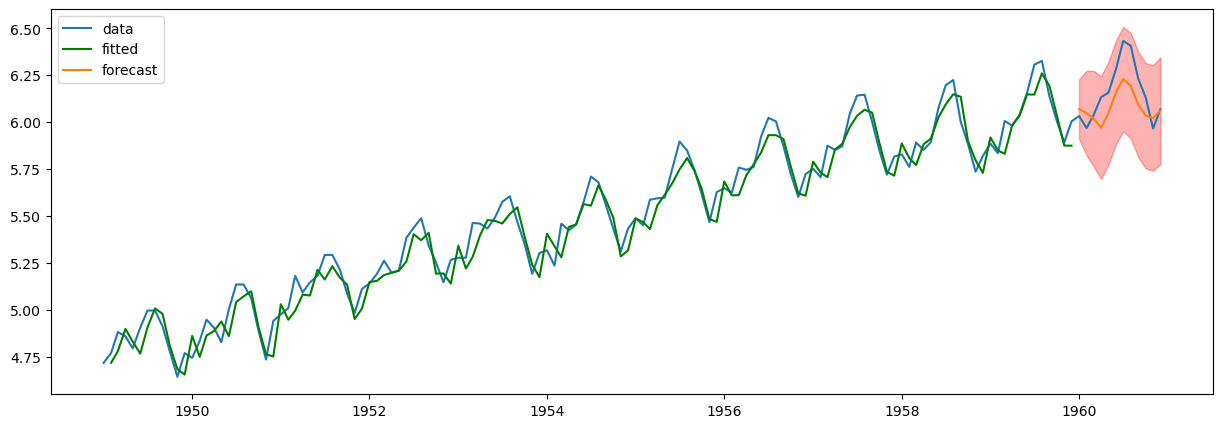

In [26]:
# Fitting an ARIMA model with the same p,d and q values but this time for the logged data
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

As we can see, our model still does decently well, it captures the seasonality, but it still underestimates the peak.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


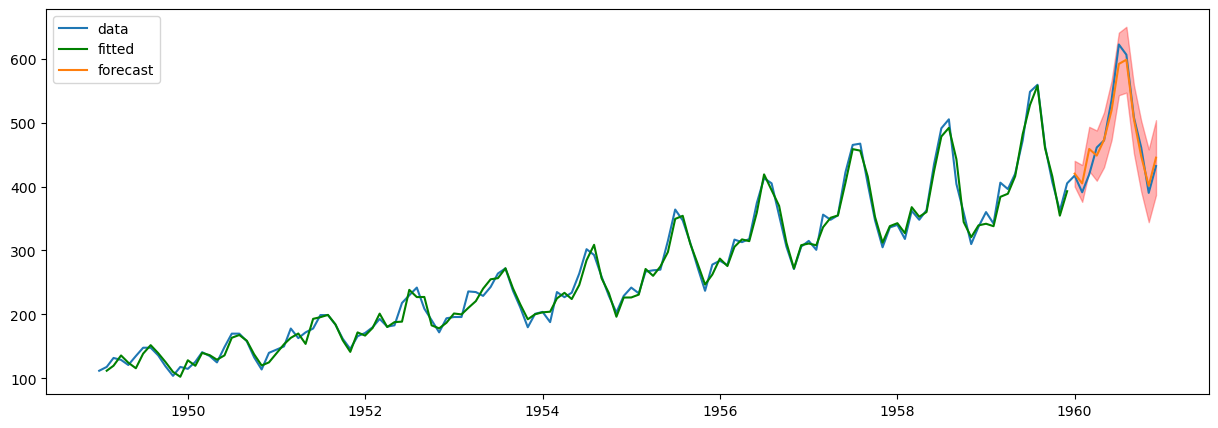

In [27]:
# Trying a different ARMIA order
arima = ARIMA(train['Passengers'], order=(12,1,0)) # p is chosen as 12 because that's the length of the period (12 months). Note that this is not a hard and fast rule to always choose the period
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='Passengers')

It seems like this is our best model so far

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


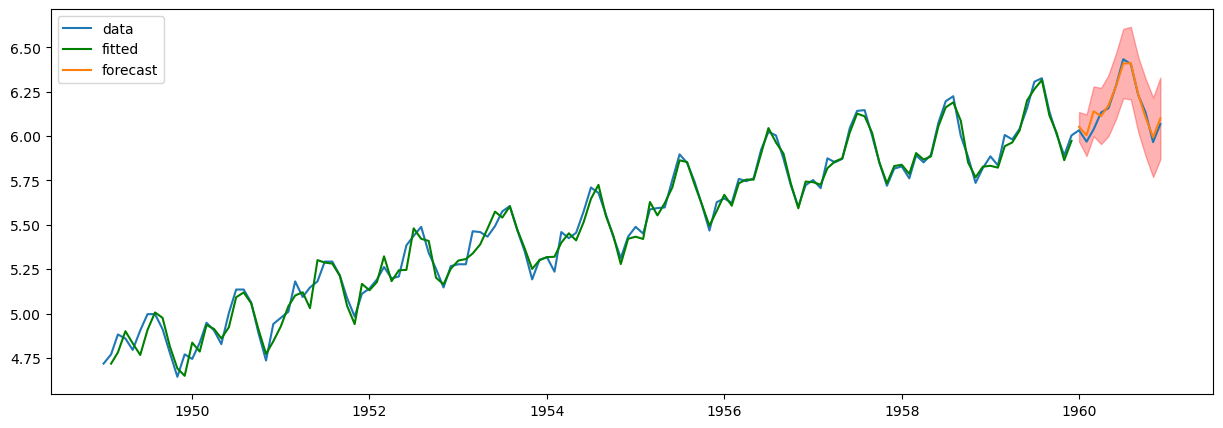

In [28]:
# Trying the same p,d and q values for logged data
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

Again, it looks pretty good. Maybe even better than the last one.

In [29]:
# The RMSE function takes in 2 arguments, the ARIMA result and a flag that tells us whether the model was fitted on the "LogPassengers"
def rmse(result, is_logged):
    # Inside the function we call "result.forecast()" to get the forecast
    forecast = result.forecast(Ntest)
    # If is_logged is True than we exponentiate the forecast to put the data back into the original scale
    if is_logged:
        forecast = np.exp(forecast)
    
    # Assigning the test df to a variable called 't'
    t = test['Passengers']
    # Assigning forecast to a variable called 'y'
    y = forecast
    # Return the value for RMSE formula
    return np.sqrt(np.mean((t - y)**2))

In [30]:
# Comparing RMSE for the last 4 models we created
print("ARIMA(8,1,1)        :", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged :", rmse(arima_result_log811, True))
print("ARIMA(12,1,0)       :", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1)        : 59.06458657739681
ARIMA(8,1,1) logged : 61.60410178699154
ARIMA(12,1,0)       : 17.483957583532877
ARIMA(12,1,0) logged: 16.115589657304067


The best combination appears to be a ARIMA(12,1,0) with logging.

---------------------------

### Auto ARIMA

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Loading Dataset
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [33]:
# Checking Dataset
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [34]:
# Taking the log of the "Passengers" column
df['LogPassengers'] = np.log(df['Passengers'])

In [35]:
# Splitting the data into train and test set, with the last 12 points assigned to the test set.
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [36]:
import pmdarima as pm

In [37]:
# Calling the auto_arima() function
model = pm.auto_arima(train['Passengers'],      # the 1st argument is the data 
                      trace=True,               # Setting trace to true helps us in seeing which models Auto ARIMA tests out while it tries to find the best model.
                      suppress_warnings=True,   # Supresses the warnings
                      seasonal=True, m=12)      # Seasonal = True, sets a full seasonal ARIMA model, which we want;   m=12, since we know that seaonal periods = 12. 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.83 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.33 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.23 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [38]:
# Calling model.predict()
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

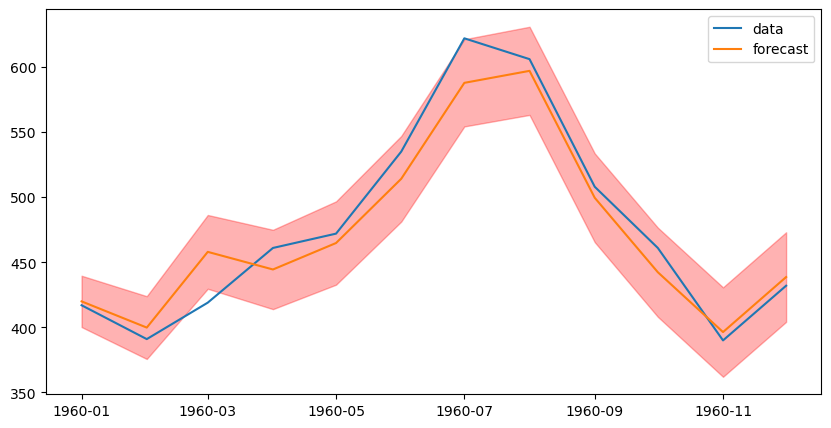

In [39]:
# Plotting the forecast along with the true values

# Creating an axis object and setting the figure size
fig, ax = plt.subplots(figsize=(10, 5))
# Call the plot() function on the "test df" and label it as "data"
ax.plot(test.index, test['Passengers'], label='data')
# Call the plot() function on the "test predictions" and label it as "forecast"
ax.plot(test.index, test_pred, label='forecast')
# Call the fill_between() function which will plot the confidence bounds
# As with statsmodels, the confidence bounds are returned as T/2 array, so each row represents "timestamp" and each column represents either the "lower bound" or the "upper bound"
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
# Calling ax.legend() to plot the labels
ax.legend();

Our forecast looks pretty good.

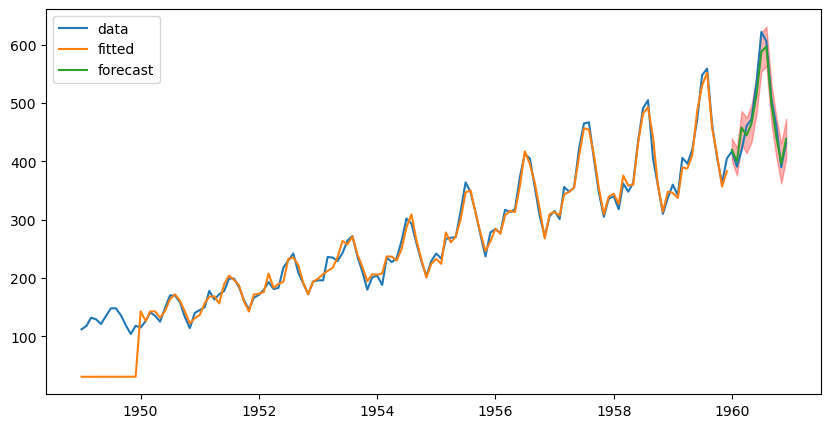

In [40]:
# Plotting the full model prediction. This will include both the "forecast" and the "in-sample" predictions

# First calling the function model.predict_in_sample(). We'll pass in start=0 and end=-1 to get the full training predictions 
train_pred = model.predict_in_sample(start=0, end=-1)

# Calling the usual plot() functions to make our plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['Passengers'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

Both the train predictions and forecast look pretty good. 

One weird part about this graph is the beginning, where all we see is a flat line. Since we now have a "seasonal" model its not possible to make predictions for the first few timestamps.  This is due to the fact that we require values from one season behind, which doesn't exist.

---------------------

Since we know that our model might perform better on the log dataset, we're going to run our Auto ARIMA again, but on the log passengers. Otherwise, all the arguments to this function are the same as before.

In [41]:
# Calling the auto_arima() function on Log model (i.e., "LogPassengers")
logmodel = pm.auto_arima(train['LogPassengers'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-439.629, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-433.026, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-444.326, Time=0.73 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-414.783, Time=0.42 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-442.328, Time=2.14 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-436.716, Time=1.20 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-445.563, Time=1.22 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-414.732, Time=0.44 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-439.504, Time=1.56 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-443.483, Time=3.16 sec
 ARIMA(1,0,2)(1,1,0)[12]

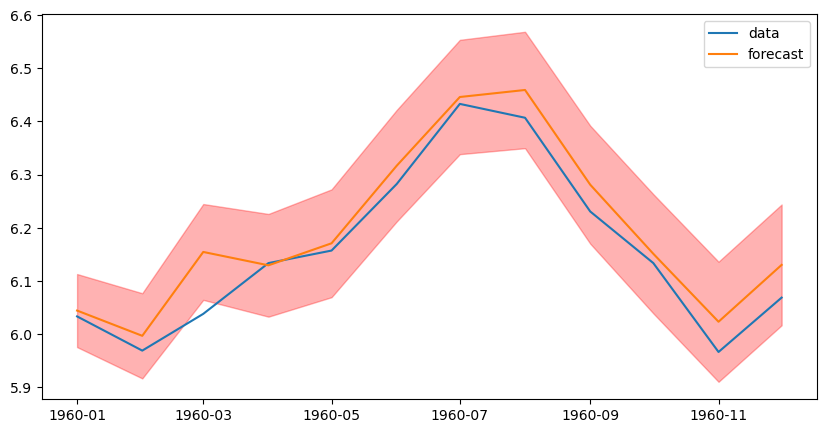

In [42]:
# Plotting the forecast along with the true values for log model

test_pred_log, confint = logmodel.predict(n_periods=Ntest, return_conf_int=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['LogPassengers'], label='data')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

The results look pretty good.

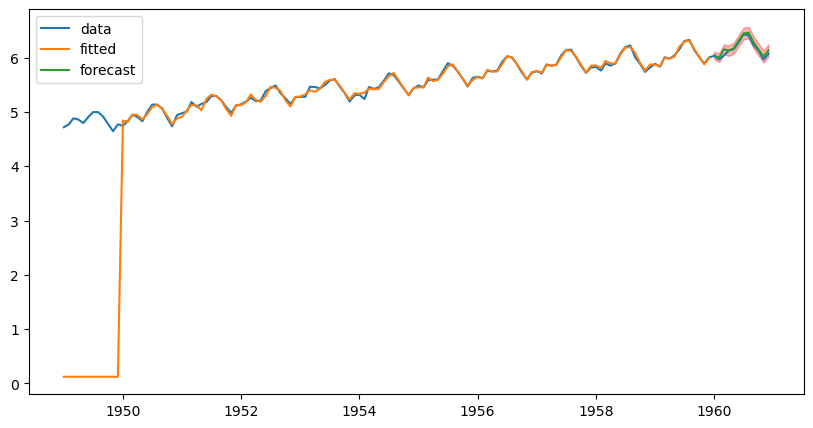

In [43]:
# Plotting the full model prediction. This will include both the "forecast" and the "in-sample" predictions for "log model"

train_pred_log = logmodel.predict_in_sample(start=0, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogPassengers'], label='data')
ax.plot(train.index, train_pred_log, label='fitted')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

Again, the model fits pretty good to the data and the forecast seems to be pretty close.

-------------------

Now, since both of these models look to be performing pretty well, it might be a good idea to test them quantitatively i.e., to use the RMSE.

In [44]:
# Forecasting RMSE
def rmse(t, y):
    return np.sqrt(np.mean((t - y)**2))

In [45]:
print("Non-logged RMSE:", rmse(test['Passengers'], test_pred))
print("Logged RMSE    :", rmse(test['Passengers'], np.exp(test_pred_log)))

Non-logged RMSE: 18.53646857871128
Logged RMSE    : 23.045012091658556


In this case, the Non-logged version performs better.

---------------

Now, the next thing we would like to do is to test Auto ARIMA itself. We want to know, can Auto ARIMA find the model that we found last time. So we're going to call Auto ARIMA again on the log passengers.

This time we're going to set a few more parameters into this function.

In [46]:
### non-seasonal
model = pm.auto_arima(train['LogPassengers'],
                      trace=True,
                      suppress_warnings=True,
                      
                      max_p=12, max_q=2, max_order=14, 
                      
                      # we set max_p=12, max_q=2. 
                      # If we look at the documentation these values are set quite low by default.
                      # So if we want Auto ARIMA to even have a chance of finding the model that we found, we have to set them higher.
                      
                      # Note that we also have to set a parameter called "max_order". This value acts as a limit on the total sum of all the ARIMA orders, which promotes finding a simpler model. 
                      # Again, the default value is 5, which is very small. So in order to have a chance of finding our previous model, we need to set this higher. 
                      # We've set it to 14 since that's the sum of 12 and 2.
                      
                      stepwise=False,
                      
                      # The "stepwise" argument controls whether we use an intelligent algorithm to search the hyper parameter space or if we use a naive grid search. 
                      # The default value for this is true. We've set this to False for now and let's see how it performs.
                      
                      # Note - Setting stepwise to True did not yield good results. Hence we've set it to False. 
                      # Also it's not a good idea to run this code if the seasonal component was also computed, as it would take a lot more time to process.
                      
                      seasonal=False,
                      
                      # Finally, we set "seasonal=False", since our goal right now is to compare these results to the results from the previous script (i.e., ARIMA(12,1,0) we found from trial and error).
                      error_action="ignore")
                      # Set by me to ignore errors. 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.983, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-214.718, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.069, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-216.622, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-240.230, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-216.024, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-245.883, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-246.313, Time=0.45 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-229.057, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-227.139, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-251.142, Time=0.68 sec
 ARIMA(5,1,0)(0,0,0)[0] i

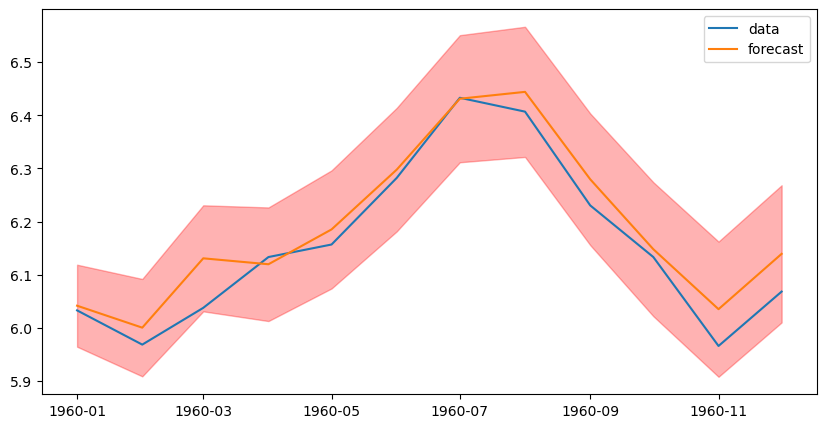

In [47]:
# Plotting our model forecast

test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['LogPassengers'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

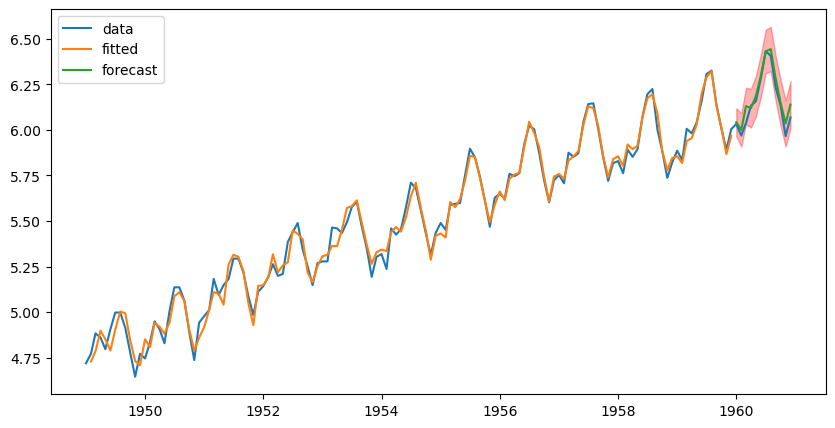

In [48]:
# Plotting the full model prediction.

train_pred = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogPassengers'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

In [49]:
rmse(test['Passengers'], np.exp(test_pred))

20.736511001021178

This is actually quite interesting because this is a worst model than the model we found on our own.

As you recall, ARIMA(12,1,0) achieves 18 something RMSE. Furthermore, that model has less parameters than this one (i.e., the 0 part in ARIMA(12,1,0)). So this model actually gets a higher penalty for having one more parameter(i.e., ARIMA(12,1,1), the extra parameter being q).

So what this tells us is that finding the best AIC is not the same as minimizing the out-of-sample error.

They are similar ideas in concept, but one is looking for a simpler model purely to look for a simpler
model, while the other doesn't actually care about model complexity, but rather accuracy. So these two ideas are related, but they are not the same.

-------------------------

In [50]:
### non-seasonal non-logged
model = pm.auto_arima(train['Passengers'],
                      trace=True,
                      suppress_warnings=True,
                      max_p=12, max_q=2, max_order=14,
                      stepwise=False,
                      seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1261.216, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1254.439, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1245.588, Time=0.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept  

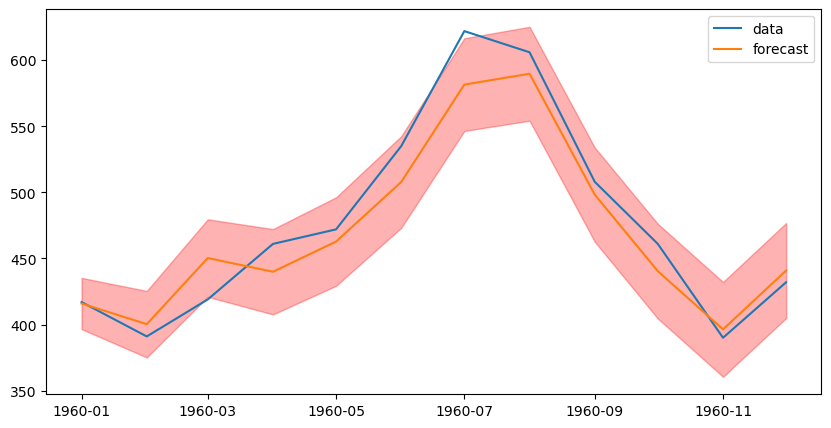

In [51]:
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['Passengers'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend();

In [52]:
rmse(test['Passengers'], test_pred)

20.149164616921627

Again, this is a worst model compared to ARIMA(12,1,0) that we did earlier.